##### import libraries

In [1]:
import numpy as np
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
from skimage import io
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
import tensorflow as tf
from tensorflow.keras import layers
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization
from keras.regularizers import l2


##### read the trianing files and join

In [2]:
# Read the CSV file into a DataFrame
df = pd.read_csv("Emergency_Vehicles/train.csv")

# Load the image data from the train subfolder
def load_image(row):
    # Read the image and return it
    image_path = os.path.join("Emergency_Vehicles/train", 
                              row["image_names"])
    image = io.imread(image_path)
    return image

image_data = df.apply(load_image, axis=1)

# Merge the DataFrame with the image data
df = df.join(pd.DataFrame(image_data, columns=["image"]))

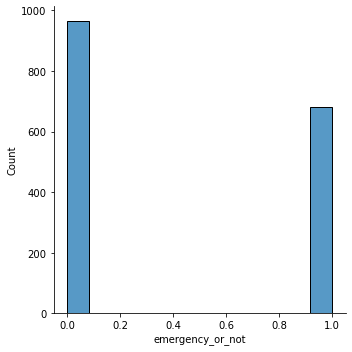

In [3]:
sns.displot(df["emergency_or_not"])

##### select features and label from the joined data

In [4]:
df.head(2)

,image_names,emergency_or_not,image
0,1503.jpg,0,"[[[94, 96, 72], [98, 100, 79], [110, 111, 97],..."
1,1420.jpg,0,"[[[216, 233, 251], [217, 234, 252], [216, 235,..."


In [5]:
X = df["image"].to_list()
y = df["emergency_or_not"].to_list()

In [6]:
# convert to numpy array
x_array = np.array(X)
y_array = np.array(y)

In [7]:
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(x_array, y_array, test_size=0.2, random_state=42)

In [8]:
X_train.shape, y_train.shape

((1316, 224, 224, 3), (1316,))

##### Build model

In [9]:
model = Sequential()

  #1st layer
model.add(Conv2D(24, kernel_size=(5,5), strides=(1,1), input_shape=(224, 224, 3), activation="relu"))
model.add(MaxPooling2D(pool_size=(2,2)))

  #2nd layer
model.add(Conv2D(36, kernel_size=(5,5), strides=(1,1), activation="relu"))
model.add(MaxPooling2D(pool_size=(2,2)))

  #3rd layer
model.add(Conv2D(48, kernel_size=(3,3), strides=(1,1), activation="relu"))
model.add(MaxPooling2D(pool_size=(2,2)))
    
  #4th layer
model.add(Conv2D(64, kernel_size=(3,3), activation="relu"))
model.add(MaxPooling2D(pool_size=(2,2)))
  

  #1st Dense Layer
model.add(Flatten())
model.add(Dense(250, activation="relu"))
model.add(Dropout(0.5))

  #2nd Dense Layer
model.add(Dense(125, activation="relu"))
model.add(Dropout(0.5))

  #output
model.add(Dense(1, activation="sigmoid"))

# compile the architecture
model.compile(loss = "binary_crossentropy", optimizer = "adam", metrics = "accuracy")
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 220, 220, 24)      1824      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 110, 110, 24)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 106, 106, 36)      21636     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 53, 53, 36)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 51, 51, 48)        15600     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 25, 25, 48)       0

In [10]:
# fit the model
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test), batch_size=20)

Epoch 1/10
66/66 [==============================] - 63s 919ms/step - loss: 1.6392 - accuracy: 0.5752 - val_loss: 0.5513 - val_accuracy: 0.6697
Epoch 2/10
66/66 [==============================] - 60s 917ms/step - loss: 0.5533 - accuracy: 0.7044 - val_loss: 0.4802 - val_accuracy: 0.8061
Epoch 3/10
66/66 [==============================] - 59s 893ms/step - loss: 0.4848 - accuracy: 0.7850 - val_loss: 0.4603 - val_accuracy: 0.8000
Epoch 4/10
66/66 [==============================] - 68s 1s/step - loss: 0.3782 - accuracy: 0.8442 - val_loss: 0.4967 - val_accuracy: 0.8152
Epoch 5/10
66/66 [==============================] - 71s 1s/step - loss: 0.3433 - accuracy: 0.8632 - val_loss: 0.4789 - val_accuracy: 0.7606
Epoch 6/10
66/66 [==============================] - 70s 1s/step - loss: 0.2820 - accuracy: 0.8883 - val_loss: 0.5190 - val_accuracy: 0.8000
Epoch 7/10
66/66 [==============================] - 70s 1s/step - loss: 0.2651 - accuracy: 0.8898 - val_loss: 0.4957 - val_accuracy: 0.7939
Epoch 8/10


##### Evaluation

In [11]:
# make prediction 
pred = model.predict(X_test)
np_pred =  np.round(pred)

# make evaluation
print("Confusion Matrix: \n",confusion_matrix(y_test,np_pred))
print(classification_report(y_test,np_pred))
print("Model Accuracy: ", accuracy_score(y_test, np_pred))

11/11 [==============================] - 3s 283ms/step
Confusion Matrix: 
 [[166  32]
 [ 31 101]]
              precision    recall  f1-score   support

           0       0.84      0.84      0.84       198
           1       0.76      0.77      0.76       132

    accuracy                           0.81       330
   macro avg       0.80      0.80      0.80       330
weighted avg       0.81      0.81      0.81       330

Model Accuracy:  0.8090909090909091


Text(0.5, 1.0, 'Confusion Matrix')

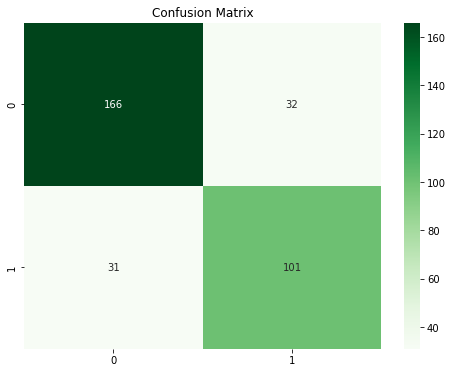

In [12]:
# plot confusion matrix 
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(list(y_test), np_pred, labels=[0, 1]), annot=True, cmap="Greens", fmt="g")
plt.title("Confusion Matrix")

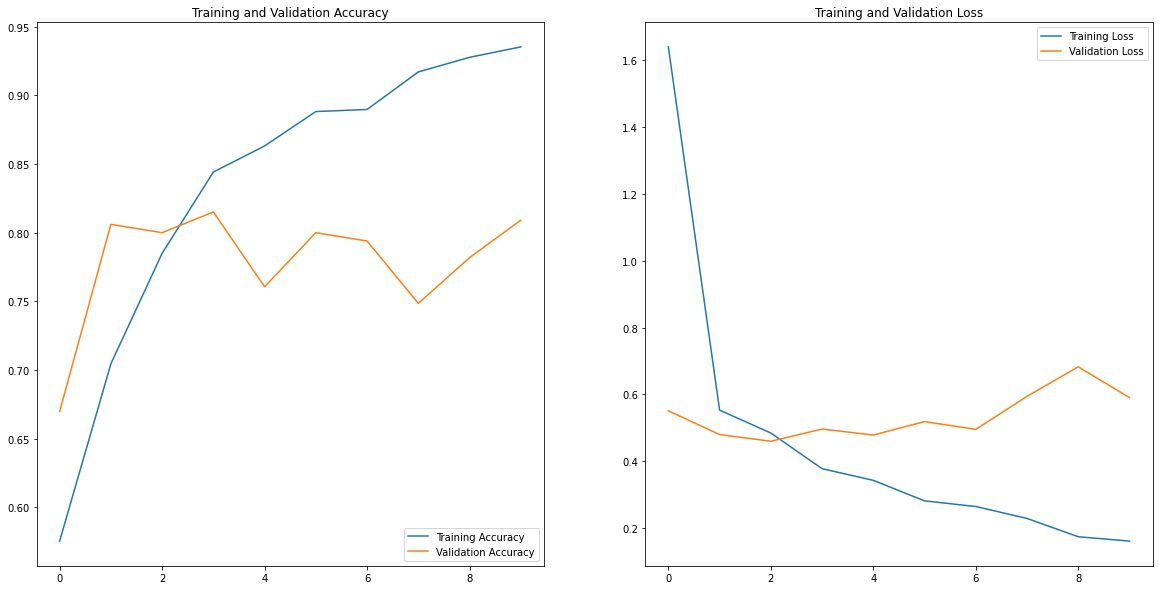

In [13]:
## plotting loss and accuracy
import matplotlib.pyplot as plt

train_acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]


train_loss = history.history["loss"]
val_loss = history.history["val_loss"]

epochs_range = range(10)
plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_acc, label="Training Accuracy")
plt.plot(epochs_range, val_acc, label="Validation Accuracy")
plt.legend(loc="lower right")
plt.title("Training and Validation Accuracy")

plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_loss, label="Training Loss")
plt.plot(epochs_range, val_loss, label="Validation Loss")
plt.legend(loc="upper right")
plt.title("Training and Validation Loss")
plt.show()

##### Load test files

In [14]:
# load the test.csv file and extract the list of image names
test_df = pd.read_csv("Emergency_Vehicles/test.csv")
image_names = test_df["image_names"].to_list()

# filter the list of image names to only include those in the test folder 

filtered_image = [name for name in image_names if os.path.exists(os.path.join("Emergency_Vehicles/test", name))]

In [15]:
import cv2

#   function to resize the image to the correct dimensions
def preprocess_image(img):
    img = cv2.resize(img, (224, 224))
    img = img.astype(np.float32) / 255.0
    return img

In [16]:
# load the images and preprocess them
test_images = []

for name in filtered_image:

  # load the image
  img = cv2.imread(os.path.join("Emergency_Vehicles/test", name))

  # preprocess the image to match the model"s input format
  img = preprocess_image(img)

  # add the preprocessed image to the list
  test_images.append(img)

In [17]:
# convert the list of images to a NumPy array
test_images = np.array(test_images)

# generate predictions for the test images using the model
predictions = model.predict(test_images)
round_pred = np.round(predictions)

23/23 [==============================] - 7s 299ms/step


C:\Users\user\anaconda3\lib\site-packages\matplotlib\text.py:1223: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


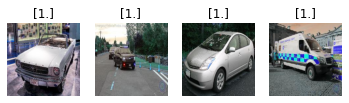

In [18]:
# Set the number of images per batch
batch_size = 4

# Get the predicted class labels for the current batch
predicted_labels = round_pred[:batch_size]

# Get the corresponding images for the current batch
images = test_images[:batch_size]

# Create a figure with a grid of subplots
fig, axes = plt.subplots(1, batch_size)

# Loop through the subplots and plot the images

for i in range(batch_size):
    # Plot the image
    axes[i].imshow(images[i])
    axes[i].set_title(predicted_labels[i])
    axes[i].axis("off")

# Show the figure
plt.show()